# Station Outlier filter

This notebook shows the "station outlier filter" to detect... 

The original R code stems from https://github.com/LottedeVos/PWSQC/. 

Publication:
de Vos, L. W., Leijnse, H., Overeem, A., & Uijlenhoet, R. (2019). Quality control for crowdsourced personal weather stations to enable operational rainfall monitoring. _Geophysical Research Letters_, 46(15), 8820-8829.

The idea of the filter is to... 

In [1]:
import numpy as np
import xarray as xr
import poligrain as plg
import matplotlib.pyplot as plt
import pandas as pd

In [3]:
ds_pws = xr.open_dataset('OpenSense_PWS_example_format_data.nc')

#slice to one month
ds_pws = ds_pws.sel(time = slice('2017-07-01','2017-07-31'))

## Calculate distance matrix

In [4]:
ds_pws.coords["x"], ds_pws.coords["y"] = plg.spatial.project_point_coordinates(
    x=ds_pws.longitude, y=ds_pws.latitude, target_projection="EPSG:25832"
)

In [5]:
distance_matrix = plg.spatial.calc_point_to_point_distances(ds_pws, ds_pws)

## SO filter (fixed evaluation period only)

In [6]:
# Set parameters
mint = 4032
mrain = 100
mmatch = 200
gamma = 0.35 # 0.15 original (gives very few SO-flags)
beta = 0.2
n_stat = 5
max_distance = 10e3 # Boolean 2D data array, defining neihbours within max_distance for all stations
dbc = 1

In [6]:
# initalize data variables
ds_pws['so_flag'] = xr.DataArray(np.ones((len(ds_pws.id), len(ds_pws.time)))*-999, dims=("id", "time"))
ds_pws['mean_corr_nbrs'] = xr.DataArray(np.ones((len(ds_pws.id), len(ds_pws.time)))*-999, dims=("id", "time"))

In [7]:
# this takes 35 sec for one station, for the whole time series, when the time series is one month long
i = 0
ds_station = ds_pws.isel(id=i) 
pws_id = ds_station.id.values

# one bias correction factor per station, iteratively updated PER TIME STEP ??
BCF_prev = dbc

# picking stations within max_distnance, excluding itself, for the whole duration of the time series
neighbor_ids = distance_matrix.id.data[(distance_matrix.sel(id=pws_id) < max_distance) & (distance_matrix.sel(id=pws_id) > 0)]

#create data set for neighbors
ds_neighbors = ds_pws.sel(id=neighbor_ids)

# s_station = ds_station.rainfall.to_series()
# s_neighbors = ds_neighbors.rainfall.to_series()

# ds_so_filter = so_filter(ds_station.rainfall, ds_neighbors.rainfall, window_length=mint) 
# matches = ((s_station > 0) & (s_neighbors > 0)).sum()

# matches

In [9]:
neighbor_ids

array(['ams2', 'ams3', 'ams4', 'ams5', 'ams6', 'ams7', 'ams8', 'ams9',
       'ams10', 'ams11', 'ams12', 'ams13', 'ams14', 'ams15', 'ams16',
       'ams17', 'ams19', 'ams20', 'ams21', 'ams23', 'ams24', 'ams26'],
      dtype='<U6')

In [68]:
# DO NOT DELETE THIS CELL
# overlap_counts = s_neighbors.apply(lambda col: ((s_station > 0) & (col > 0)).sum())

## tests med rainy timesteps...

In [48]:
def rainy_timesteps_station(da_station, window_length):
    df= da_station.to_dataframe()
    drop_columns = ['elevation', 'latitude','longitude','x','y','id']
    df= df.drop(drop_columns, axis = 1)
    rainy_timesteps = (df > 0).rolling(mint, min_periods=1).sum()
    ds = xr.Dataset.from_dataframe(pd.DataFrame({'rainy_timesteps': rainy_timesteps.rainfall}))
    return ds

In [56]:
def rainy_timesteps_neighbors(da_neighbors, window_length):
    df = da_neighbors.to_dataframe()
    drop_columns = ['elevation', 'latitude','longitude','x','y']
    df = df.drop(drop_columns, axis = 1)
    df = df["rainfall"].unstack("id")
    rainy_timesteps = (df > 0).rolling(mint, min_periods=1).sum()
    # ds = xr.Dataset.from_dataframe(pd.DataFrame({'rainy_timesteps': rainy_timesteps}))
    return rainy_timesteps
    

In [57]:
test_nbrs = rainy_timesteps_neighbors(ds_neighbors, mint)
test_nbrs

id,ams2,ams3,ams4,ams5,ams6,ams7,ams8,ams9,ams10,ams11,...,ams14,ams15,ams16,ams17,ams19,ams20,ams21,ams23,ams24,ams26
time,,,,,,,,,,,,,,,,,,,,,
2017-07-01 00:00:00,1.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,...,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0
2017-07-01 00:05:00,2.0,0.0,2.0,0.0,2.0,2.0,2.0,1.0,0.0,0.0,...,2.0,1.0,2.0,2.0,2.0,0.0,1.0,2.0,2.0,2.0
2017-07-01 00:10:00,3.0,0.0,3.0,0.0,3.0,3.0,3.0,2.0,0.0,0.0,...,2.0,2.0,3.0,3.0,3.0,0.0,2.0,3.0,3.0,3.0
2017-07-01 00:15:00,4.0,0.0,4.0,0.0,4.0,4.0,4.0,3.0,0.0,0.0,...,3.0,3.0,4.0,4.0,4.0,0.0,3.0,4.0,4.0,4.0
2017-07-01 00:20:00,5.0,0.0,5.0,0.0,5.0,5.0,5.0,4.0,0.0,0.0,...,4.0,4.0,5.0,5.0,5.0,0.0,4.0,5.0,5.0,5.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-07-31 23:35:00,216.0,187.0,191.0,0.0,206.0,169.0,296.0,142.0,2.0,0.0,...,196.0,209.0,166.0,174.0,206.0,199.0,194.0,218.0,256.0,278.0
2017-07-31 23:40:00,216.0,187.0,191.0,0.0,206.0,169.0,296.0,142.0,2.0,0.0,...,196.0,209.0,166.0,174.0,206.0,199.0,194.0,218.0,256.0,278.0
2017-07-31 23:45:00,216.0,187.0,191.0,0.0,206.0,169.0,296.0,142.0,2.0,0.0,...,196.0,209.0,166.0,174.0,206.0,199.0,194.0,218.0,256.0,278.0


In [59]:
test_nbrs.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 8928 entries, 2017-07-01 00:00:00 to 2017-07-31 23:55:00
Data columns (total 22 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   ams2    8928 non-null   float64
 1   ams3    8928 non-null   float64
 2   ams4    8928 non-null   float64
 3   ams5    8928 non-null   float64
 4   ams6    8928 non-null   float64
 5   ams7    8928 non-null   float64
 6   ams8    8928 non-null   float64
 7   ams9    8928 non-null   float64
 8   ams10   8928 non-null   float64
 9   ams11   8928 non-null   float64
 10  ams12   8928 non-null   float64
 11  ams13   8928 non-null   float64
 12  ams14   8928 non-null   float64
 13  ams15   8928 non-null   float64
 14  ams16   8928 non-null   float64
 15  ams17   8928 non-null   float64
 16  ams19   8928 non-null   float64
 17  ams20   8928 non-null   float64
 18  ams21   8928 non-null   float64
 19  ams23   8928 non-null   float64
 20  ams24   8928 non-null   float64
 21  a

In [41]:
df = ds_neighbors.to_dataframe()
drop_columns = ['elevation', 'latitude','longitude','x','y']
df = df.drop(drop_columns, axis = 1)
df = df["rainfall"].unstack("id")
rainy_timesteps = (df > 0).rolling(mint, min_periods=1).sum()
ds = xr.Dataset.from_dataframe(pd.DataFrame({'rainy_timesteps': rainy_timesteps}))
ds

ValueError: If using all scalar values, you must pass an index

In [21]:


ds = xr.Dataset.from_dataframe(pd.DataFrame({'rainy_timesteps': rainy_timesteps.rainfall}))

<xarray.Dataset>
Dimensions:          (time: 8928)
Coordinates:
  * time             (time) datetime64[ns] 2017-07-01 ... 2017-07-31T23:55:00
Data variables:
    rainy_timesteps  (time) float64 1.0 2.0 3.0 4.0 ... 190.0 190.0 190.0 190.0

In [ ]:
    rainy_timesteps = (df > 0).rolling(mint, min_periods=1).sum()
    # rainy_timesteps = roll_neighbors.where(df_count > 5).notnull().astype(int).sum(axis=1)

    # df_all = pd.concat([df_station, df_neighbors], axis=1)
    
    # rainy_timesteps = (df_all > 0).rolling(window_length, min_periods=1).sum()
    ds = xr.Dataset.from_dataframe(pd.DataFrame({'rainy_timesteps': rainy_timesteps}))

    # compare if rainy timesteps is above threshold mrain
    # if true --> apply SO-filter as it is now (fixed window)
    # if false ---> go back in time?
    return ds

In [106]:
yup = rainy_timesteps_neighbors(ds_neighbors.rainfall, mint)
yup

id,ams2,ams3,ams4,ams5,ams6,ams7,ams8,ams9,ams10,ams11,...,ams14,ams15,ams16,ams17,ams19,ams20,ams21,ams23,ams24,ams26
time,,,,,,,,,,,,,,,,,,,,,
2017-07-01 00:00:00,1.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,...,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0
2017-07-01 00:05:00,2.0,0.0,2.0,0.0,2.0,2.0,2.0,1.0,0.0,0.0,...,2.0,1.0,2.0,2.0,2.0,0.0,1.0,2.0,2.0,2.0
2017-07-01 00:10:00,3.0,0.0,3.0,0.0,3.0,3.0,3.0,2.0,0.0,0.0,...,2.0,2.0,3.0,3.0,3.0,0.0,2.0,3.0,3.0,3.0
2017-07-01 00:15:00,4.0,0.0,4.0,0.0,4.0,4.0,4.0,3.0,0.0,0.0,...,3.0,3.0,4.0,4.0,4.0,0.0,3.0,4.0,4.0,4.0
2017-07-01 00:20:00,5.0,0.0,5.0,0.0,5.0,5.0,5.0,4.0,0.0,0.0,...,4.0,4.0,5.0,5.0,5.0,0.0,4.0,5.0,5.0,5.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-07-31 23:35:00,216.0,187.0,191.0,0.0,206.0,169.0,296.0,142.0,2.0,0.0,...,196.0,209.0,166.0,174.0,206.0,199.0,194.0,218.0,256.0,278.0
2017-07-31 23:40:00,216.0,187.0,191.0,0.0,206.0,169.0,296.0,142.0,2.0,0.0,...,196.0,209.0,166.0,174.0,206.0,199.0,194.0,218.0,256.0,278.0
2017-07-31 23:45:00,216.0,187.0,191.0,0.0,206.0,169.0,296.0,142.0,2.0,0.0,...,196.0,209.0,166.0,174.0,206.0,199.0,194.0,218.0,256.0,278.0


In [9]:
# ds = xr.Dataset.from_dataframe(pd.DataFrame({'rainy_timesteps': yup}))

In [87]:
roll_neighbors = (df_neighbors > 0).rolling(mint, min_periods=1).sum()
roll_neighbors =

id,ams2,ams3,ams4,ams5,ams6,ams7,ams8,ams9,ams10,ams11,...,ams14,ams15,ams16,ams17,ams19,ams20,ams21,ams23,ams24,ams26
time,,,,,,,,,,,,,,,,,,,,,
2017-07-01 00:00:00,1.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,...,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0
2017-07-01 00:05:00,2.0,0.0,2.0,0.0,2.0,2.0,2.0,1.0,0.0,0.0,...,2.0,1.0,2.0,2.0,2.0,0.0,1.0,2.0,2.0,2.0
2017-07-01 00:10:00,3.0,0.0,3.0,0.0,3.0,3.0,3.0,2.0,0.0,0.0,...,2.0,2.0,3.0,3.0,3.0,0.0,2.0,3.0,3.0,3.0
2017-07-01 00:15:00,4.0,0.0,4.0,0.0,4.0,4.0,4.0,3.0,0.0,0.0,...,3.0,3.0,4.0,4.0,4.0,0.0,3.0,4.0,4.0,4.0
2017-07-01 00:20:00,5.0,0.0,5.0,0.0,5.0,5.0,5.0,4.0,0.0,0.0,...,4.0,4.0,5.0,5.0,5.0,0.0,4.0,5.0,5.0,5.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-07-31 23:35:00,216.0,187.0,191.0,0.0,206.0,169.0,296.0,142.0,2.0,0.0,...,196.0,209.0,166.0,174.0,206.0,199.0,194.0,218.0,256.0,278.0
2017-07-31 23:40:00,216.0,187.0,191.0,0.0,206.0,169.0,296.0,142.0,2.0,0.0,...,196.0,209.0,166.0,174.0,206.0,199.0,194.0,218.0,256.0,278.0
2017-07-31 23:45:00,216.0,187.0,191.0,0.0,206.0,169.0,296.0,142.0,2.0,0.0,...,196.0,209.0,166.0,174.0,206.0,199.0,194.0,218.0,256.0,278.0


In [94]:
roll_neighbors.where(df_count > 5).notnull().astype(int).sum(axis=1)

time
2017-07-01 00:00:00     0
2017-07-01 00:05:00     0
2017-07-01 00:10:00     0
2017-07-01 00:15:00     0
2017-07-01 00:20:00     0
                       ..
2017-07-31 23:35:00    19
2017-07-31 23:40:00    19
2017-07-31 23:45:00    19
2017-07-31 23:50:00    19
2017-07-31 23:55:00    19
Length: 8928, dtype: int64

In [53]:
# dfsum(axis=1)

df_count[ df_count > 5].sum(axis = 1)

time
2017-07-01 00:00:00       0.0
2017-07-01 00:05:00       0.0
2017-07-01 00:10:00       0.0
2017-07-01 00:15:00       0.0
2017-07-01 00:20:00       0.0
                        ...  
2017-07-31 23:35:00    4121.0
2017-07-31 23:40:00    4121.0
2017-07-31 23:45:00    4121.0
2017-07-31 23:50:00    4122.0
2017-07-31 23:55:00    4122.0
Length: 8928, dtype: float64

In [54]:
df_count[ df_count > 5]

,rainfall,ams2,ams3,ams4,ams5,ams6,ams7,ams8,ams9,ams10,...,ams14,ams15,ams16,ams17,ams19,ams20,ams21,ams23,ams24,ams26
time,,,,,,,,,,,,,,,,,,,,,
2017-07-01 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-07-01 00:05:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-07-01 00:10:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-07-01 00:15:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-07-01 00:20:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-07-31 23:35:00,190.0,216.0,187.0,191.0,NaN,206.0,169.0,296.0,142.0,NaN,...,196.0,209.0,166.0,174.0,206.0,199.0,194.0,218.0,256.0,278.0
2017-07-31 23:40:00,190.0,216.0,187.0,191.0,NaN,206.0,169.0,296.0,142.0,NaN,...,196.0,209.0,166.0,174.0,206.0,199.0,194.0,218.0,256.0,278.0
2017-07-31 23:45:00,190.0,216.0,187.0,191.0,NaN,206.0,169.0,296.0,142.0,NaN,...,196.0,209.0,166.0,174.0,206.0,199.0,194.0,218.0,256.0,278.0


In [77]:
hej = df_count.where(df_count > 5)
hej

,rainfall,ams2,ams3,ams4,ams5,ams6,ams7,ams8,ams9,ams10,...,ams14,ams15,ams16,ams17,ams19,ams20,ams21,ams23,ams24,ams26
time,,,,,,,,,,,,,,,,,,,,,
2017-07-01 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-07-01 00:05:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-07-01 00:10:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-07-01 00:15:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-07-01 00:20:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-07-31 23:35:00,190.0,216.0,187.0,191.0,NaN,206.0,169.0,296.0,142.0,NaN,...,196.0,209.0,166.0,174.0,206.0,199.0,194.0,218.0,256.0,278.0
2017-07-31 23:40:00,190.0,216.0,187.0,191.0,NaN,206.0,169.0,296.0,142.0,NaN,...,196.0,209.0,166.0,174.0,206.0,199.0,194.0,218.0,256.0,278.0
2017-07-31 23:45:00,190.0,216.0,187.0,191.0,NaN,206.0,169.0,296.0,142.0,NaN,...,196.0,209.0,166.0,174.0,206.0,199.0,194.0,218.0,256.0,278.0


In [88]:
roll_neighbors.where(df_count > 5).notnull().astype(int).sum(axis=1)

time
2017-07-01 00:00:00     0
2017-07-01 00:05:00     0
2017-07-01 00:10:00     0
2017-07-01 00:15:00     0
2017-07-01 00:20:00     0
                       ..
2017-07-31 23:35:00    19
2017-07-31 23:40:00    19
2017-07-31 23:45:00    19
2017-07-31 23:50:00    19
2017-07-31 23:55:00    19
Length: 8928, dtype: int64

In [81]:
hej.notnull().astype(int).sum(axis=1)

time
2017-07-01 00:00:00     0
2017-07-01 00:05:00     0
2017-07-01 00:10:00     0
2017-07-01 00:15:00     0
2017-07-01 00:20:00     0
                       ..
2017-07-31 23:35:00    20
2017-07-31 23:40:00    20
2017-07-31 23:45:00    20
2017-07-31 23:50:00    20
2017-07-31 23:55:00    20
Length: 8928, dtype: int64

In [73]:
test1 = df_count.where(df_count > 5, other=pd.NA)
test1

,rainfall,ams2,ams3,ams4,ams5,ams6,ams7,ams8,ams9,ams10,...,ams14,ams15,ams16,ams17,ams19,ams20,ams21,ams23,ams24,ams26
time,,,,,,,,,,,,,,,,,,,,,
2017-07-01 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-07-01 00:05:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-07-01 00:10:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-07-01 00:15:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-07-01 00:20:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-07-31 23:35:00,190.0,216.0,187.0,191.0,NaN,206.0,169.0,296.0,142.0,NaN,...,196.0,209.0,166.0,174.0,206.0,199.0,194.0,218.0,256.0,278.0
2017-07-31 23:40:00,190.0,216.0,187.0,191.0,NaN,206.0,169.0,296.0,142.0,NaN,...,196.0,209.0,166.0,174.0,206.0,199.0,194.0,218.0,256.0,278.0
2017-07-31 23:45:00,190.0,216.0,187.0,191.0,NaN,206.0,169.0,296.0,142.0,NaN,...,196.0,209.0,166.0,174.0,206.0,199.0,194.0,218.0,256.0,278.0


In [74]:
# test1.where(test1 is not np.nan, other= 1 )
test1.where(test1 == pd.NA, other= 1)

,rainfall,ams2,ams3,ams4,ams5,ams6,ams7,ams8,ams9,ams10,...,ams14,ams15,ams16,ams17,ams19,ams20,ams21,ams23,ams24,ams26
time,,,,,,,,,,,,,,,,,,,,,
2017-07-01 00:00:00,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
2017-07-01 00:05:00,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
2017-07-01 00:10:00,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
2017-07-01 00:15:00,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
2017-07-01 00:20:00,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-07-31 23:35:00,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
2017-07-31 23:40:00,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
2017-07-31 23:45:00,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


In [67]:
test1

,rainfall,ams2,ams3,ams4,ams5,ams6,ams7,ams8,ams9,ams10,...,ams14,ams15,ams16,ams17,ams19,ams20,ams21,ams23,ams24,ams26
time,,,,,,,,,,,,,,,,,,,,,
2017-07-01 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-07-01 00:05:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-07-01 00:10:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-07-01 00:15:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-07-01 00:20:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-07-31 23:35:00,190.0,216.0,187.0,191.0,NaN,206.0,169.0,296.0,142.0,NaN,...,196.0,209.0,166.0,174.0,206.0,199.0,194.0,218.0,256.0,278.0
2017-07-31 23:40:00,190.0,216.0,187.0,191.0,NaN,206.0,169.0,296.0,142.0,NaN,...,196.0,209.0,166.0,174.0,206.0,199.0,194.0,218.0,256.0,278.0
2017-07-31 23:45:00,190.0,216.0,187.0,191.0,NaN,206.0,169.0,296.0,142.0,NaN,...,196.0,209.0,166.0,174.0,206.0,199.0,194.0,218.0,256.0,278.0


In [49]:
df_count = (df_all > 0).rolling(mint, min_periods=1).sum()
df_count

,rainfall,ams2,ams3,ams4,ams5,ams6,ams7,ams8,ams9,ams10,...,ams14,ams15,ams16,ams17,ams19,ams20,ams21,ams23,ams24,ams26
time,,,,,,,,,,,,,,,,,,,,,
2017-07-01 00:00:00,1.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,...,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0
2017-07-01 00:05:00,2.0,2.0,0.0,2.0,0.0,2.0,2.0,2.0,1.0,0.0,...,2.0,1.0,2.0,2.0,2.0,0.0,1.0,2.0,2.0,2.0
2017-07-01 00:10:00,3.0,3.0,0.0,3.0,0.0,3.0,3.0,3.0,2.0,0.0,...,2.0,2.0,3.0,3.0,3.0,0.0,2.0,3.0,3.0,3.0
2017-07-01 00:15:00,4.0,4.0,0.0,4.0,0.0,4.0,4.0,4.0,3.0,0.0,...,3.0,3.0,4.0,4.0,4.0,0.0,3.0,4.0,4.0,4.0
2017-07-01 00:20:00,5.0,5.0,0.0,5.0,0.0,5.0,5.0,5.0,4.0,0.0,...,4.0,4.0,5.0,5.0,5.0,0.0,4.0,5.0,5.0,5.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-07-31 23:35:00,190.0,216.0,187.0,191.0,0.0,206.0,169.0,296.0,142.0,2.0,...,196.0,209.0,166.0,174.0,206.0,199.0,194.0,218.0,256.0,278.0
2017-07-31 23:40:00,190.0,216.0,187.0,191.0,0.0,206.0,169.0,296.0,142.0,2.0,...,196.0,209.0,166.0,174.0,206.0,199.0,194.0,218.0,256.0,278.0
2017-07-31 23:45:00,190.0,216.0,187.0,191.0,0.0,206.0,169.0,296.0,142.0,2.0,...,196.0,209.0,166.0,174.0,206.0,199.0,194.0,218.0,256.0,278.0


In [ ]:
# This is the count of wet neighbors for each time stamp
neighbors_wet_count = (da_station_and_neighbors.rainfall_amount.sel(id=neighbor_ids) > 0).sum(dim='id')
# This is a boolean array with True for wet station to be flagged
station_wet = da_station_and_neighbors.rainfall_amount.sel(id=current_station_id) > 0

neighbors_wet_count_and_station_wet = neighbors_wet_count.where(station_wet)
matches = neighbors_wet_count_and_station_wet.rolling().sum()

In [ ]:
# if rainfall < mmatch at station AND at least nstat nbrs with rainfall above mmatch

## SO-filter

In [47]:
def so_filter(da_station, da_neighbors, window_length):
    
    s_station = da_station.to_series()
    s_neighbors = da_neighbors.to_series()

    #create dataframe of neighboring stations
    df = da_neighbors.to_dataframe()
    drop_columns = ['elevation', 'latitude','longitude','x','y']
    df = df.drop(drop_columns, axis = 1)
    df = df["rainfall"].unstack("id")

    corr = s_station.rolling(window_length, min_periods=1).corr(s_neighbors)

    # number of matching rainy time steps in evaluation period
    number_of_rainy_neighbors  = (df > 0).sum(axis=1)
    rainy_timestep_at_station = s_station > 0
    matches = number_of_rainy_neighbors.where(rainy_timestep_at_station).rolling(mint, min_periods=1).sum()
    
    # rainy_timesteps = (s_neighbors > 0).rolling(window_length, min_periods=1).sum()
    # np.nanmean(ds_station.rainfall - ds_so_filter.roll_mean_nbrs) / np.nanmean(ds_so_filter.roll_mean_nbrs)

    # matches = ((s_station > 0) & (s_neighbors > 0).sum()

    # the row below is what takes time to do, the rest is very fast
    # matches = s_neighbors.apply(lambda col: ((s_station > 0) & (col > 0)).sum())

    # this makes the whole thing explode
    # matches = s_neighbors.apply(lambda col: ((s_station > 0) & (col > 0)).rolling(window_length, min_periods=1).sum())
    ds = xr.Dataset.from_dataframe(pd.DataFrame({'corr': corr}))
    # ds['rainy_timesteps'] = xr.DataArray.from_series(rainy_timesteps)
    ds['matches'] = xr.DataArray.from_series(matches)
    
    return ds

In [48]:
test = so_filter(ds_station.rainfall, ds_neighbors.rainfall, mint)
test

<xarray.Dataset>
Dimensions:  (id: 22, time: 8928)
Coordinates:
  * id       (id) object 'ams2' 'ams3' 'ams4' 'ams5' ... 'ams23' 'ams24' 'ams26'
  * time     (time) datetime64[ns] 2017-07-01 ... 2017-07-31T23:55:00
Data variables:
    corr     (id, time) float64 nan 1.0 0.5 -1.36e-15 ... 0.08503 0.0849 0.0849
    matches  (time) float64 14.0 29.0 45.0 ... 1.698e+03 1.698e+03 1.698e+03

In [ ]:
subset_stations = ['station_1', 'station_3', 'station_5']  # Replace with your actual column names

# Filter the DataFrame to only include the selected subset of stations
subset_df = df[subset_stations]

# Apply the condition (rainfall > 0) and sum across the columns (stations) for each row (time step)
count_of_stations = (subset_df > 0).sum(axis=1)

In [ ]:
neighbors_wet_count = (da_station_and_neighbors.rainfall_amount.sel(id=neighbor_ids) > 0).sum(dim='id')

In [33]:
subset_stations = ['station_1', 'station_3', 'station_5']  # Replace with your actual column names

# Filter the DataFrame to only include the selected subset of stations
subset_df = df[subset_stations]

# Apply the condition (rainfall > 0) and sum across the columns (stations) for each row (time step)
count_of_stations = (subset_df > 0).sum(axis=1)

array(['ams2', 'ams3', 'ams4', 'ams5', 'ams6', 'ams7', 'ams8', 'ams9',
       'ams10', 'ams11', 'ams12', 'ams13', 'ams14', 'ams15', 'ams16',
       'ams17', 'ams19', 'ams20', 'ams21', 'ams23', 'ams24', 'ams26'],
      dtype='<U6')

In [41]:
s_station = ds_pws.rainfall.sel(id=pws_id).to_series()

rainy_timestep_at_station = s_station > 0

rainy_timestep_at_station 

time
2017-07-01 00:00:00     True
2017-07-01 00:05:00     True
2017-07-01 00:10:00     True
2017-07-01 00:15:00     True
2017-07-01 00:20:00     True
                       ...  
2017-07-31 23:35:00    False
2017-07-31 23:40:00    False
2017-07-31 23:45:00    False
2017-07-31 23:50:00    False
2017-07-31 23:55:00    False
Name: rainfall, Length: 8928, dtype: bool

In [42]:
number_of_rainy_neighbors

time
2017-07-01 00:00:00    14
2017-07-01 00:05:00    15
2017-07-01 00:10:00    16
2017-07-01 00:15:00    17
2017-07-01 00:20:00    17
                       ..
2017-07-31 23:35:00     1
2017-07-31 23:40:00     0
2017-07-31 23:45:00     0
2017-07-31 23:50:00     1
2017-07-31 23:55:00     0
Length: 8928, dtype: int64

In [45]:
matches = number_of_rainy_neighbors.where(rainy_timestep_at_station).rolling(mint, min_periods=1).sum()
matches

time
2017-07-01 00:00:00      14.0
2017-07-01 00:05:00      29.0
2017-07-01 00:10:00      45.0
2017-07-01 00:15:00      62.0
2017-07-01 00:20:00      79.0
                        ...  
2017-07-31 23:35:00    1698.0
2017-07-31 23:40:00    1698.0
2017-07-31 23:45:00    1698.0
2017-07-31 23:50:00    1698.0
2017-07-31 23:55:00    1698.0
Length: 8928, dtype: float64

In [46]:
matches < mmatch

time
2017-07-01 00:00:00     True
2017-07-01 00:05:00     True
2017-07-01 00:10:00     True
2017-07-01 00:15:00     True
2017-07-01 00:20:00     True
                       ...  
2017-07-31 23:35:00    False
2017-07-31 23:40:00    False
2017-07-31 23:45:00    False
2017-07-31 23:50:00    False
2017-07-31 23:55:00    False
Length: 8928, dtype: bool

In [44]:
number_of_rainy_neighbors.where(rainy_timestep_at_station).rolling(mint, min_periods=1).sum()

time
2017-07-01 00:00:00      14.0
2017-07-01 00:05:00      29.0
2017-07-01 00:10:00      45.0
2017-07-01 00:15:00      62.0
2017-07-01 00:20:00      79.0
                        ...  
2017-07-31 23:35:00    1698.0
2017-07-31 23:40:00    1698.0
2017-07-31 23:45:00    1698.0
2017-07-31 23:50:00    1698.0
2017-07-31 23:55:00    1698.0
Length: 8928, dtype: float64

In [37]:
df = ds_pws.sel(id=neighbor_ids).rainfall.to_dataframe()
drop_columns = ['elevation', 'latitude','longitude','x','y']
df = df.drop(drop_columns, axis = 1)
df = df["rainfall"].unstack("id")
df

# number_of_rainy_neighbors  = (df > 0).sum(axis=1)

id,ams2,ams3,ams4,ams5,ams6,ams7,ams8,ams9,ams10,ams11,...,ams14,ams15,ams16,ams17,ams19,ams20,ams21,ams23,ams24,ams26
time,,,,,,,,,,,,,,,,,,,,,
2017-07-01 00:00:00,0.101,0.0,0.202,NaN,0.303,0.101,0.202,0.000,NaN,0.0,...,0.303,0.101,0.202,0.202,0.404,NaN,0.000,0.303,0.234,0.101
2017-07-01 00:05:00,0.202,0.0,0.303,NaN,0.202,0.202,0.202,0.404,NaN,0.0,...,0.202,0.000,0.101,0.202,0.303,NaN,0.101,0.303,0.234,0.101
2017-07-01 00:10:00,0.202,0.0,0.202,NaN,0.202,0.101,0.202,0.101,NaN,0.0,...,0.000,0.202,0.101,0.101,0.101,NaN,0.101,0.202,0.585,0.101
2017-07-01 00:15:00,0.101,0.0,0.101,NaN,0.101,0.101,0.101,0.202,NaN,0.0,...,0.202,0.202,0.101,0.101,0.202,NaN,0.202,0.101,0.351,0.202
2017-07-01 00:20:00,0.202,0.0,0.303,NaN,0.101,0.101,0.101,0.101,NaN,0.0,...,0.202,0.202,0.202,0.202,0.101,NaN,0.202,0.101,0.585,0.303
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-07-31 23:35:00,0.000,0.0,0.000,NaN,0.000,0.000,0.000,0.000,0.0,0.0,...,0.000,0.000,0.000,0.000,0.000,0.0,0.000,0.000,0.000,0.101
2017-07-31 23:40:00,0.000,0.0,0.000,NaN,0.000,0.000,0.000,0.000,0.0,0.0,...,0.000,0.000,0.000,0.000,0.000,0.0,0.000,0.000,0.000,0.000
2017-07-31 23:45:00,0.000,0.0,0.000,NaN,0.000,0.000,0.000,0.000,0.0,0.0,...,0.000,0.000,0.000,0.000,0.000,0.0,0.000,0.000,0.000,0.000


In [40]:
number_of_rainy_neighbors  = (df > 0).sum(axis=1)
number_of_rainy_neighbors  

time
2017-07-01 00:00:00    14
2017-07-01 00:05:00    15
2017-07-01 00:10:00    16
2017-07-01 00:15:00    17
2017-07-01 00:20:00    17
                       ..
2017-07-31 23:35:00     1
2017-07-31 23:40:00     0
2017-07-31 23:45:00     0
2017-07-31 23:50:00     1
2017-07-31 23:55:00     0
Length: 8928, dtype: int64

In [18]:
# THIS IS A CORRECT CELL
# (da_station_and_neighbors.rainfall_amount.sel(id=neighbor_ids) > 0).sum(dim='id')
# ds_pws.rainfall.sel(id = neighbor_ids)

#rain_greater_than_zero = subset_rainfall > 0
#count_of_stations = rain_greater_than_zero.sum(dim='station')

number_of_rainy_neighbors = (ds_pws.rainfall.sel(id = neighbor_ids) > 0 ).sum(dim='id')

# This is a boolean array with True for wet station to be flagged
rainy_timestep_at_station = ds_pws.rainfall.sel(id=pws_id) > 0


In [25]:
neighbors_wet_count_and_station_wet = number_of_rainy_neighbors.where(rainy_timestep_at_station)
#matches = neighbors_wet_count_and_station_wet.rolling(mint, min_periods=1).sum()
#matches

In [29]:


#what is this the first two weeks really..... 
yup = neighbors_wet_count_and_station_wet.to_series()

# s_station = da_station.to_series()

In [33]:
yup_roll= yup.rolling(mint, min_periods=1).sum()

<Axes: xlabel='time'>

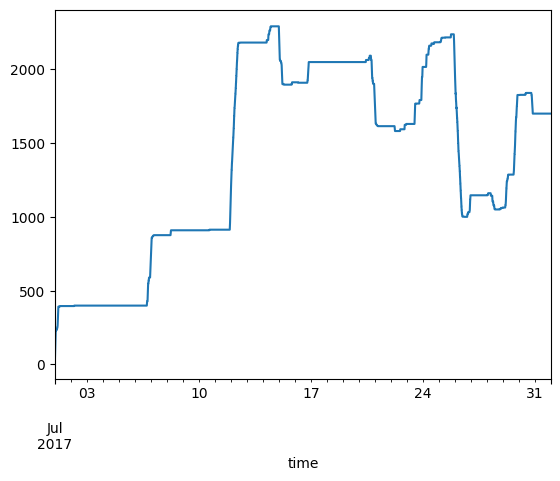

In [35]:
yup_roll.plot()

In [ ]:
# This is the count of wet neighbors for each time stamp
neighbors_wet_count = (da_station_and_neighbors.rainfall_amount.sel(id=neighbor_ids) > 0).sum(dim='id')
# This is a boolean array with True for wet station to be flagged
station_wet = da_station_and_neighbors.rainfall_amount.sel(id=current_station_id) > 0

neighbors_wet_count_and_station_wet = neighbors_wet_count.where(station_wet)
matches = neighbors_wet_count_and_station_wet.rolling().sum()

In [12]:
(ds_pws.rainfall.sel(ds_pws.rainfall.sel(id=neighbor_ids)) > 0)

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

In [43]:
neighbors_wet_count = (ds_pws.rainfall.sel(id=neighbor_ids) > 0).sum(dim='time')
neighbors_wet_count

<xarray.DataArray 'rainfall' (id: 22)>
array([459, 344, 368,   0, 465, 366, 551, 355,   2,   0, 457, 423, 439,
       446, 390, 402, 309, 226, 444, 459, 519, 566])
Coordinates:
  * id         (id) <U6 'ams2' 'ams3' 'ams4' 'ams5' ... 'ams23' 'ams24' 'ams26'
    elevation  (id) <U3 ...
    latitude   (id) float64 52.3 52.31 52.35 52.32 ... 52.26 52.34 52.28 52.28
    longitude  (id) float64 4.675 4.677 4.678 4.679 ... 4.763 4.781 4.783 4.795
    x          (id) float64 2.052e+05 2.054e+05 ... 2.124e+05 2.132e+05
    y          (id) float64 5.803e+06 5.804e+06 5.808e+06 ... 5.8e+06 5.8e+06

In [45]:
neighbors_wet_count.isel(id = 9)

<xarray.DataArray 'rainfall' ()>
array(0)
Coordinates:
    id         <U6 'ams11'
    elevation  <U3 ...
    latitude   float64 52.25
    longitude  float64 4.703
    x          float64 2.067e+05
    y          float64 5.797e+06

In [42]:
station_wet = (ds_pws.rainfall.sel(id=pws_id) > 0).sum()
station_wet.data

array(465)

In [37]:
ds_pws.rainfall.sel(id=neighbor_ids)

<xarray.DataArray 'rainfall' (id: 22, time: 8928)>
[196416 values with dtype=float64]
Coordinates:
  * time       (time) datetime64[ns] 2017-07-01 ... 2017-07-31T23:55:00
  * id         (id) <U6 'ams2' 'ams3' 'ams4' 'ams5' ... 'ams23' 'ams24' 'ams26'
    elevation  (id) <U3 ...
    latitude   (id) float64 52.3 52.31 52.35 52.32 ... 52.26 52.34 52.28 52.28
    longitude  (id) float64 4.675 4.677 4.678 4.679 ... 4.763 4.781 4.783 4.795
    x          (id) float64 2.052e+05 2.054e+05 ... 2.124e+05 2.132e+05
    y          (id) float64 5.803e+06 5.804e+06 5.808e+06 ... 5.8e+06 5.8e+06
Attributes:
    name:                   rainfall
    long_name:              rainfall amount per time unit
    units:                  mm
    coverage_contant_type:  physicalMeasurement

In [10]:
%%time

for i in [0,1,2,3,4]: # range(len(ds_pws.id)):

    # create data set for station i
    ds_station = ds_pws.isel(id=i) 
    pws_id = ds_station.id.values

    # one bias correction factor per station, iteratively updated PER TIME STEP ??
    BCF_prev = dbc

    # picking stations within max_distnance, excluding itself, for the whole duration of the time series
    neighbor_ids = distance_matrix.id.data[(distance_matrix.sel(id=pws_id) < max_distance) & (distance_matrix.sel(id=pws_id) > 0)]

    #create data set for neighbors
    ds_neighbors = ds_pws.sel(id=neighbor_ids)

    # run so-filter
    ds_so_filter = so_filter(ds_station.rainfall, ds_neighbors.rainfall, window_length=mint)

    # if there are no observations in the time series, filter cannot be applied
    if ds_pws.rainfall.sel(id=pws_id).isnull().all():
        print(pws_id, " has no data")
        ds_pws.so_flag[i, :] = -1
        
    # if there are not enough stations nearby, filter cannot be applied
    elif (len(neighbor_ids) < n_stat):
        # print(pws_id, "has less than", n_stat, "neighbors")
        ds_pws.so_flag[i, :] = -1

    elif
    xr.where(ds_so_filter.rainy_timesteps < mmatch, -2, -4)
    
    elif ds_so_filter.enough_matches.isel(id = i) == False:
    #    ds_pws.so_flag[i, :] = -1
    
     #enough_matches = rainy_timesteps < mmatch
    # matches = rainy_timesteps(ds_station.rainfall, ds_neighbors.rainfall, window_length=mint)
    # ds_pws.rainy_timesteps = matches
    # ds_pws['so_flag'] = xr.where(matches.rainy_timesteps < mmatch, -2, -4)
    
    #else: 
        # print("calculating SO-flag for", pws_id)
        #ds_so_filter = so_filter(ds_station.rainfall, ds_neighbors.rainfall, window_length=mint)
        #mean_corr = ds_so_filter.corr.mean(dim = "id", skipna = True)
        #ds_pws.mean_corr_nbrs[i, :] = mean_corr
        #ds_pws.so_flag[i,:] = xr.where(ds_pws.mean_corr_nbrs.isel(id = i) < gamma , -1, 0) 


ams5  has no data
CPU times: total: 562 ms
Wall time: 549 ms


In [84]:
# xr.where(ds_so_filter.rainy_timesteps < mmatch, -2, -4)

## Bias (next step to fix - how to calculate ROLLING bias?) 

In [6]:
ds_pws

<xarray.Dataset>
Dimensions:    (time: 8928, id: 134)
Coordinates:
  * time       (time) datetime64[ns] 2017-07-01 ... 2017-07-31T23:55:00
  * id         (id) <U6 'ams1' 'ams2' 'ams3' ... 'ams132' 'ams133' 'ams134'
    elevation  (id) <U3 ...
    latitude   (id) float64 52.31 52.3 52.31 52.35 ... 52.31 52.43 52.3 52.26
    longitude  (id) float64 4.671 4.675 4.677 4.678 ... 5.032 5.036 5.041 5.045
    x          (id) float64 2.049e+05 2.052e+05 ... 2.301e+05 2.301e+05
    y          (id) float64 5.804e+06 5.803e+06 ... 5.802e+06 5.798e+06
Data variables:
    rainfall   (id, time) float64 ...
Attributes:
    title:                 PWS data from Amsterdam
    file author:           Maximilian Graf
    institution:           Wageningen University and Research, Department of ...
    date:                  2022-10-18 10:32:00
    source:                Netamo PWS
    history:               Data derived and reformated from the originally pu...
    naming convention:     OpenSense-0.1
    license restrictions:  CC-BY 4.0 https://creativecommons.org/licenses/by/...
    reference:             https://doi.org/10.1029/2019GL083731
    comment:

In [7]:
# initialize 
ds_pws["bias"] = xr.DataArray(np.ones((len(ds_pws.id), len(ds_pws.time)))*-999, dims=("id", "time"))

In [8]:
#bias for the whole time series with nbrs, one station
i = 0

ds_station = ds_pws.isel(id=i) 
pws_id = ds_station.id.values

neighbor_ids = distance_matrix.id.data[(distance_matrix.sel(id=pws_id) < max_distance) & (distance_matrix.sel(id=pws_id) > 0)]
ds_neighbors = ds_pws.sel(id=neighbor_ids)

s_station = ds_station.rainfall.to_series()
s_neighbors = ds_neighbors.rainfall.to_series()

roll_mean = s_neighbors.rolling(mint, min_periods=1).mean()
# rolling mean of neighbors, ie reference rainfall

# delta_r = s_station - s_neighbors
# delta_r
# delta_r = ds_station.rainfall - ds_neighbors.rainfall
# bias = np.nanmean(delta_r) / np.nanmean(ds_neighbors.rainfall)

# how to make rolling bias? 

In [52]:
reference_rainfall = ds_neighbors.rainfall.mean(dim = "id") # can be radar or other source
delta_r = ds_station.rainfall - reference_rainfall

In [59]:
bias = delta_r / reference_rainfall
bias

<xarray.DataArray 'rainfall' (time: 8928)>
array([-0.32902098,  0.213405  , -0.31635198, ...,         nan,
       -1.        ,         nan])
Coordinates:
  * time       (time) datetime64[ns] 2017-07-01 ... 2017-07-31T23:55:00
    id         <U6 'ams1'
    elevation  <U3 ...
    latitude   float64 52.31
    longitude  float64 4.671
    x          float64 2.049e+05
    y          float64 5.804e+06

In [16]:
def bias(station_rainfall, reference_rainfall):
    delta_r = station_rainfall - reference_rainfall
    return np.nanmean(delta_r) / np.nanmean(reference_rainfall)

In [ ]:
def bias_test(da_station, da_neighbors, window_length):
    s_station = da_station.to_series()
    s_neighbors = da_neighbors.to_series()
    bias = np.nanmean(delta_r) / np.nanmean(reference_rainfall)
    # roll_bias = s_station.rolling(window_length, min_periods=1).corr(s_neighbors)

In [17]:
# add flags to dataset
# ds_pws["bias"] = (("id", "time"), biascorrectiontable)

In [18]:
# ds_pws.to_netcdf('C:/Users/a002461/OPENSENSE/data/OpenSense_PWS_example_format_data_SO_flags.nc')

In [19]:
#so_flag = pypwsqc.flagging.so_filter(
#    ds_pws.rainfall,
#    ds_pws.nbrs_not_nan,
#    ds_pws.reference,
#    distance_matrix,
#    mint = 4032,
#    mrain = 100,
#    mmatch = 200,
#    gamma = 0.15,
#   beta = 0.2,
#    n_stat = 5,
#    max_distance = 10e3,
#)